This is a notebook exploring distribution of arrivals and forecast quality in a real dataset. 

Some notebook outputs are not shown so as to not expose the raw data.

In [ ]:
!pip install prophet==1.0.1

In [ ]:
# Standard imports
import pandas as pd
import math
from datetime import datetime, timedelta
import numpy as np
import sys
import textwrap

# Prophet imports
from prophet import Prophet
from prophet.plot import (plot_plotly, plot_components_plotly, 
                           plot_forecast_component)
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# Plotting imports
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [ ]:
# Import data
imported = pd.read_csv('/work/SO test data.csv')
imported.head()

In [ ]:
# Rename columns for easier working with
ARRIVAL_COLUMN_NAME = 'Arrival Date/Time'
STREAM_COLUMN_NAME = "Stream"

imported = imported.rename({ARRIVAL_COLUMN_NAME: 'arrival_time', 
                            STREAM_COLUMN_NAME: "stream"}, 
                            axis=1)

# Add a column with no data that can just be used for counts
imported["dummy"] = 1

In [ ]:
imported

In [ ]:
imported = imported[['arrival_time', "stream", "dummy"]]

imported.head()

In [ ]:
imported['arrival_time'] = pd.to_datetime(imported['arrival_time'])

In [ ]:
imported['date'] = imported['arrival_time'].dt.date
imported['hour'] = imported['arrival_time'].dt.hour

In [ ]:
grouped = (
    imported.groupby(['date', 'hour', 'stream'])
    .count()[['dummy']]
    .reset_index()
)

grouped

In [ ]:
# Add a datetime column for the hour of arrival
# Ensure it's a datetime object rather than 
# a string
grouped['date_time_hour_start'] = (
    pd.to_datetime(grouped.date.astype('str') 
                   + ':' 
                   + grouped.hour.astype('str'), 
                   format='%Y-%m-%d:%H')
)

In [ ]:
# Select a subset of columns
grouped = grouped[['date_time_hour_start', 'stream', 'dummy']]

grouped

# Stream objects

Create an object that can contain relevant information about streams: name, minutes per decision, and priority.

In [ ]:
class Stream:
    '''
    Object to contain required information about streams.
    '''
    def __init__(self,
                 name,
                 minutes_per_decision,
                 priority,
                 historic_data_all_streams,
                 twenty_four_hour_department=True,
                 open_hour=0,
                 close_hour=0,
                 weeks_to_forecast=8):
        '''
        Constructor

        Parameters:
        -----------
        name: str
            Name of the stream (e.g. majors, minors, resus)

        minutes_per_decision: int
            Number of minutes typically required to make a clinical 
            decision for each stream.

            This will be used to calculate the decision making time
            required from the number of attendances.

        priority: int
            Order in which the stream will be seen by clinicians who
            can float across different streams 

            Lower numbers = higher priority
            i.e. stream 1 will be seen first by clinicians so should
            be set for the most urgent stream

        historic_data_all_streams: pd.DataFrame
            dataframe with three columns:
            date_time_hour_start = DateTime column at hourly intervals
            stream = Stream
            dummy = Number of arrivals in that stream in that hour

        open_hour: str
            Opening time of the emergency department
            Decimal number of hours in 24 hour time (e.g. 7am would be 7,
            7:30am would be 7.5)
            Defaults to being 24 hour
            If not 24 hour, uses this time to cut off forecasting
            after this point, improving forecast accuracy

        close_hour: float
            Closing time of the emergency department
            Decimal number of hours in 24 hour time (e.g. 6pm would be 18,
            6:30pm would be 6.5)
            Defaults to being 24 hour
            If not 24 hour, uses this time to cut off forecasting
            after this point, improving forecast accuracy
        
        weeks_to_forecast: int
            Number of weeks to run the forecast for
        '''
    
        self.name = name
        self.minutes_per_decision = minutes_per_decision
        self.priority = priority

        self.weeks_to_forecast = weeks_to_forecast

        self.twenty_four_hour_department = twenty_four_hour_department

        # TODO: Add warnings and fail to create model if this contradicts
        # the twenty_four_hour_department attribute
        self.open_hour = open_hour
        self.close_hour = close_hour
        self.historic_data = historic_data_all_streams[historic_data_all_streams['stream'] == self.name]

    def fit_prophet_model_to_stream(self, interval_width=0.95,
                                    country='England'):
        '''
        Fits a Facebook Prophet forecasting model to hourly time
        series data and returns a forecast dataframe

        Params
        ------- 
        
        interval_width: float, default 0.95
            Value between 0 and 1 that will set the width of the 
            intervals. 
            0.95 = 95% confidence interval etc.

        country: string, default 'England'
            Country to include holidays for. 
            Expected options: one of 'England', 'Wales', 'Scotland', 
            'NorthernIreland', 'Ireland'

            All valid country names can be found here:
            https://github.com/dr-prodigy/python-holidays
        '''
        # Get into correct format for Prophet
        df = (
            self.historic_data.drop('stream', axis=1)
            .rename({'date_time_hour_start': 'ds', 
                        'dummy': 'y'}, axis=1)
                        )
        
        # 8 week forecast
        model = Prophet(interval_width=interval_width)
        model.add_country_holidays(country_name=country)
        model.fit(df)
        future = model.make_future_dataframe(
            periods=24 * 7 * self.weeks_to_forecast, 
            freq='H', 
            include_history=False
            )
        
        # If not a 24 hour department, filter
        # See docs here, section 'Data with regular gaps':
        # https://facebook.github.io/prophet/docs/non-daily_data.html
        # If this isn't done then the 'daily seasonality... [will be] unconstrained
        # for the rest of the day [where there is not historical data]'
        if not self.twenty_four_hour_department:
            future_excluding_closed = future.copy()
            # Filter out time before opening
            future_excluding_closed = (
                future_excluding_closed[future_excluding_closed['ds'].dt.hour > self.open_hour]
            )
            # Filter out time after closing
            future_excluding_closed = (
                future_excluding_closed[future_excluding_closed['ds'].dt.hour < self.close_hour]
            )
            forecast_df = model.predict(future_excluding_closed)
        else:
            forecast_df = model.predict(future)

        self.prophet_model = model
        self.forecast_df = forecast_df

    def add_decision_making_time_hourly(self):
        self.forecast_df['decision_making_time_hour'] = (
            self.forecast_df['yhat'] * self.minutes_per_decision
        )
        
        self.forecast_df['decision_making_time_hour_lower'] = (
            self.forecast_df['yhat_lower'] * self.minutes_per_decision
        )
        
        self.forecast_df['decision_making_time_hour_upper'] = (
            self.forecast_df['yhat_upper'] * self.minutes_per_decision
        )

    def get_metrics(self):
        # Have to use parallel='processes' if running in Deepnote
        # as the default 'none' calls on ipywidgets, which aren't supported
        # in Deepnote but can't be specifically turned off - this is a 
        # reasonable workaround
        n_days_covered = (
            (stream_majors.historic_data.date_time_hour_start.max() 
            - stream_majors.historic_data.date_time_hour_start.min())
            .days
        )

        self.df_cv = cross_validation(self.prophet_model,
                                 initial=f'{n_days_covered - 240}  days',
                                 period='60 days',
                                 horizon=f'{24 * 7 * self.weeks_to_forecast} hours',
                                 parallel="processes",)
        
        self.performance_metrics = performance_metrics(self.df_cv)


In [ ]:
# Initialise streams
stream_majors = Stream('Majors', 60, 2, grouped)
stream_minors = Stream('Minors', 30, 3, grouped)
stream_resus = Stream('Resus', 50, 1, grouped)

In [ ]:
stream_objects = [stream_majors, stream_minors, stream_resus]

In [ ]:
# Fit models
[stream_object.fit_prophet_model_to_stream() 
 for stream_object 
 in stream_objects]

Initial log joint probability = -418.334
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       60803.7   0.000113617       274.509      0.2359      0.2359      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       60806.2   3.24998e-05       136.152   2.391e-07       0.001      265  LS failed, Hessian reset 
     199       60806.3   0.000647619           120           1           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       60807.2    9.7622e-05       241.109   9.292e-07       0.001      428  LS failed, Hessian reset 
     299       60807.2   0.000272232       159.908           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       60807.7   9.49941e-07       65.9794      0.3377       0.825      546   
Optimization terminat

[None, None, None]

## Consider the average hourly attendances per stream

In [ ]:
# Resample to ensure we have values for every hour
grouped_hs = grouped.copy()

In [ ]:
grouped_hs = (
    grouped_hs[grouped_hs['stream'].isin(['Majors', 'Minors', 'Resus'])]
    .pivot_table(values='dummy', 
                 columns='stream', 
                 index='date_time_hour_start')
    .fillna(0)
)

In [ ]:
grouped_hs = (
    grouped_hs.set_index(pd.to_datetime(grouped_hs.index))
)

In [ ]:
grouped_hs.head()

In [ ]:
grouped_hs = grouped_hs.resample('H').asfreq()

In [ ]:
plot_df = pd.melt(grouped_hs.reset_index(), id_vars='date_time_hour_start')

In [ ]:
px.box(plot_df, 
       x='stream', y='value', color='stream')

In [ ]:
plot_df['hour'] = plot_df['date_time_hour_start'].apply(lambda x: x.hour)
plot_df['month'] = plot_df['date_time_hour_start'].apply(lambda x: x.month)
plot_df['day_of_week'] = plot_df['date_time_hour_start'].apply(lambda x: x.day_of_week)


In [ ]:
px.box(plot_df, 
       x='hour', y='value', color='stream')

In [ ]:
px.box(plot_df, 
       x='month', y='value', color='stream')

In [ ]:
px.box(plot_df, 
       x='day_of_week', y='value', color='stream')

In [ ]:
px.histogram(plot_df, 
                x='value', color='stream', opacity=0.3, )

# Convert attendances to decision-making time required per hour

In [ ]:
# For any negative predictions, replace them with zero

for stream_object in stream_objects:
    for col in ['yhat', 'yhat_lower', 'yhat_upper']:
        stream_object.forecast_df[col] = (
            stream_object.forecast_df.apply(lambda x: x[col] if x[col] >=0 else 0, axis=1)
        )

In [ ]:
[stream_object.add_decision_making_time_hourly() 
 for stream_object 
 in stream_objects]

[None, None, None]

In [ ]:
stream_majors.forecast_df

# Assess forecast quality

In [ ]:
def plot_metrics_streams(stream_objects,
                         metric_of_interest,
                         figsize=(14,10),
                         sharey=True):
    '''
    Given a list of stream objects, output plots showing
    the value of a metric for assessing forecast quality
    over a range of forecast horizons 

    Parameters
    ---------

    stream_objects: list 
        list containing objects of type Stream 
        that have been fully initialised 

    metric_of_interest: string
        One of mae, mape, mse, rmse, mdape, smape, coverage 

    figsize: tuple
        Size of matplotlib plot
    '''

    fig, ax = plt.subplots(nrows=int(math.ceil(len(stream_objects)/3)), 
                           ncols=3, figsize=figsize, sharey=sharey)

    for i in range(len(stream_objects)):
        plot_cross_validation_metric(
            stream_objects[i].df_cv, 
            metric=metric_of_interest,
            ax=ax.flatten()[i]
            ) 
        # Set title for given axis
        ax.flatten()[i].title.set_text(stream_objects[i].name)
    
    fig.suptitle(metric_of_interest)

In [ ]:
# Test model quality
[stream_object.get_metrics() 
 for stream_object 
 in stream_objects]

INFO:prophet:Making 4 forecasts with cutoffs between 2020-04-14 23:00:00 and 2020-10-11 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f2598212050>
Initial log joint probability = -366.101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -299.338
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       58814.9    0.00181161       378.058           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       56945.8    0.00671261       505.448           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       58817.1    0.00031128       90.2089           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

[None, None, None]

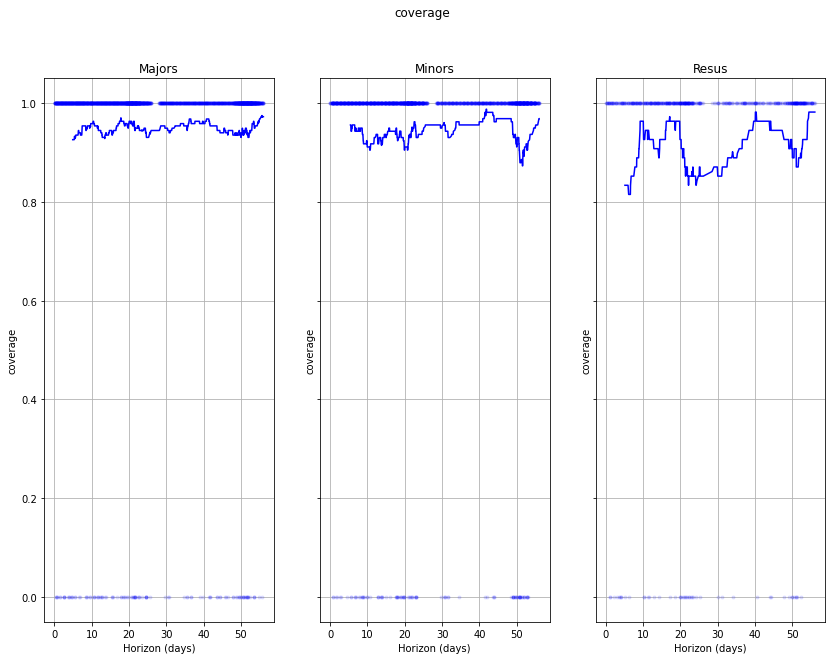

In [ ]:
plot_metrics_streams(stream_objects, "coverage")

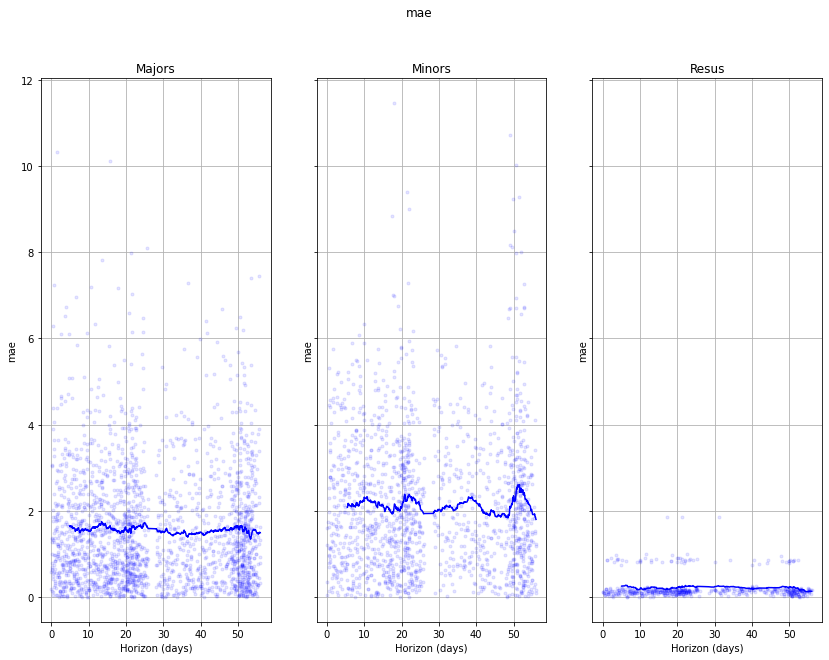

In [ ]:
plot_metrics_streams(stream_objects, "mae")

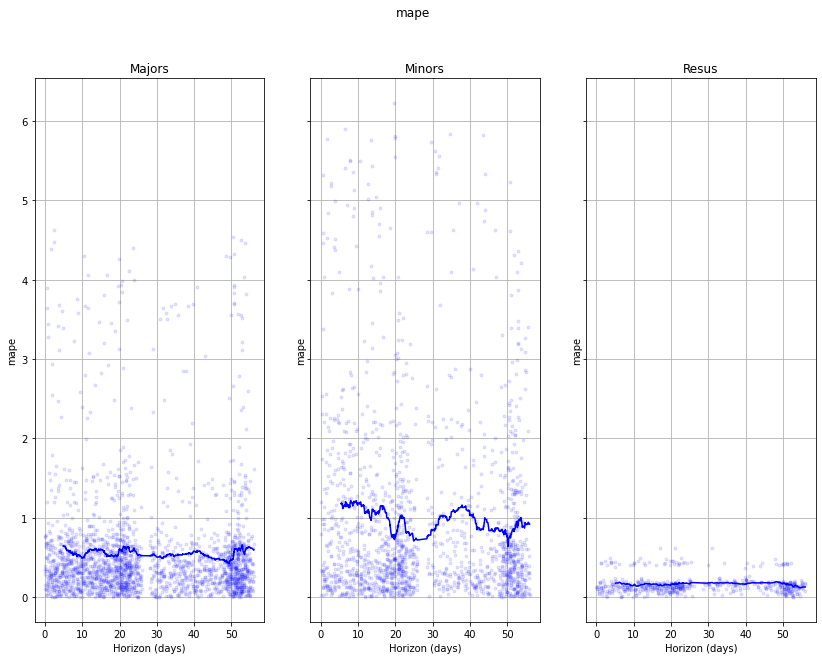

In [ ]:
plot_metrics_streams(stream_objects, "mape")

### Majors

In [ ]:
performance_metrics(stream_objects[0].df_cv).mean()

horizon     30 days 08:31:36.947935368
mse                           4.265231
rmse                          2.063692
mae                           1.554483
mape                          0.548141
mdape                         0.361569
smape                         0.453721
coverage                      0.949056
dtype: object

### Minors

In [ ]:
performance_metrics(stream_objects[1].df_cv).mean()

horizon     30 days 17:14:57.882352941
mse                           6.944813
rmse                          2.627302
mae                           2.130663
mape                          0.962053
mdape                         0.526142
smape                          0.64291
coverage                      0.942202
dtype: object

### Resus

In [ ]:
performance_metrics(stream_objects[2].df_cv).mean()

horizon     29 days 20:35:18.660287081
mse                           0.114771
rmse                          0.334099
mae                            0.21646
mape                          0.164681
mdape                         0.143857
smape                         0.170275
coverage                      0.912325
dtype: object

In [ ]:
performance_metrics_series = []

for stream in stream_objects:
    s = performance_metrics(stream.df_cv).drop('horizon', axis=1).mean().round(2)
    s['stream'] = stream.name
    performance_metrics_series.append(s)

In [ ]:
pd.DataFrame(performance_metrics_series)

mse  rmse   mae  mape  mdape  smape  coverage  stream
0  4.27  2.06  1.55  0.55   0.36   0.45      0.95  Majors
1  6.94  2.63  2.13  0.96   0.53   0.64      0.94  Minors
2  0.11  0.33  0.22  0.16   0.14   0.17      0.91   Resus

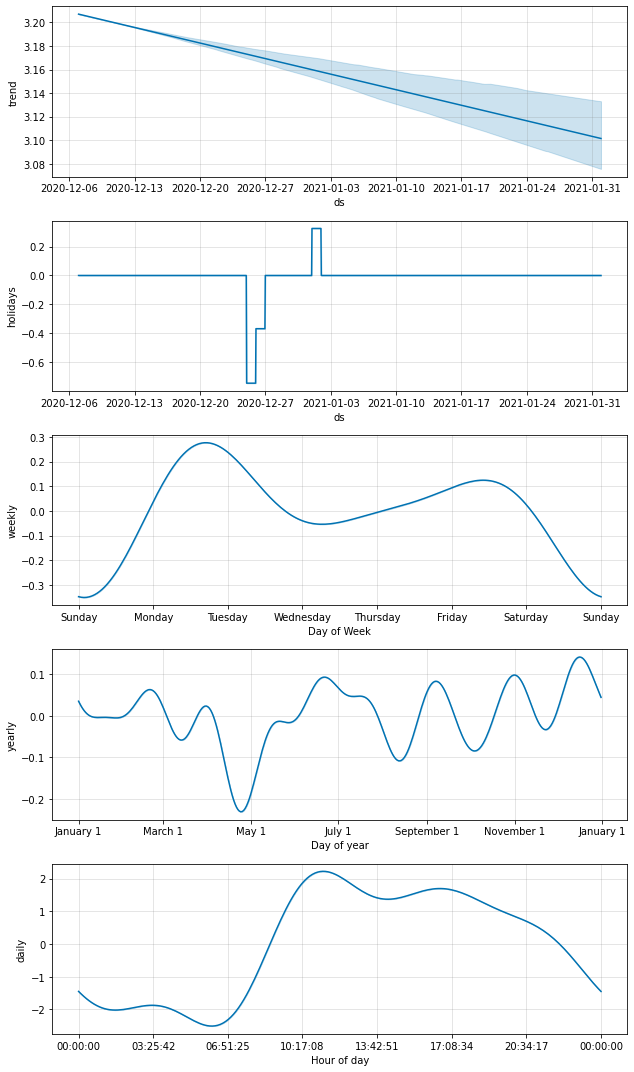

In [ ]:
stream_objects[0].prophet_model.plot_components(stream_objects[0].forecast_df);

### Majors

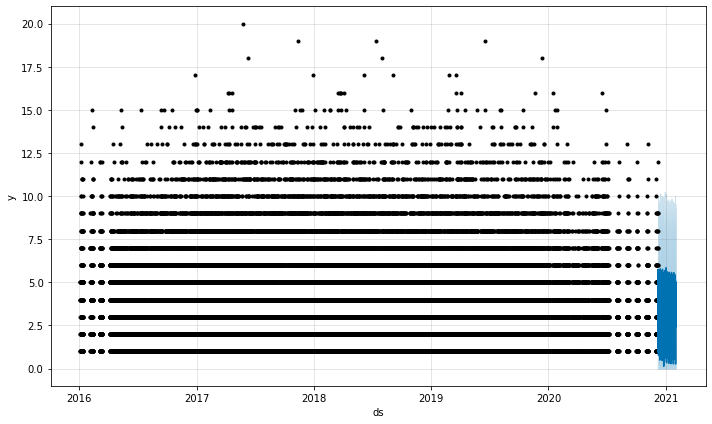

In [ ]:
stream_objects[0].prophet_model.plot(stream_objects[0].forecast_df);

### Minors

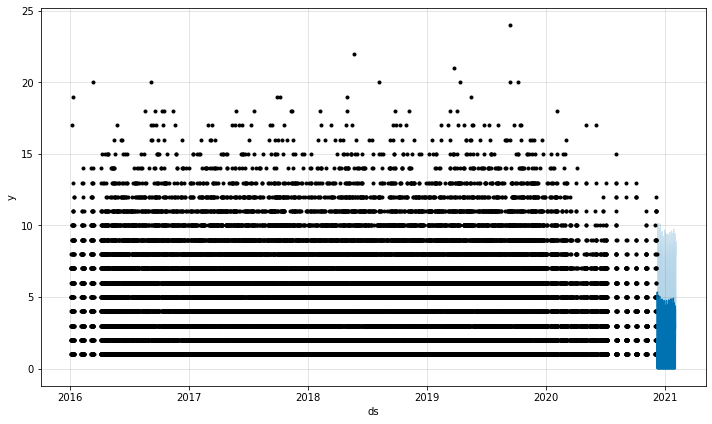

In [ ]:
stream_objects[1].prophet_model.plot(stream_objects[1].forecast_df);

### Resus

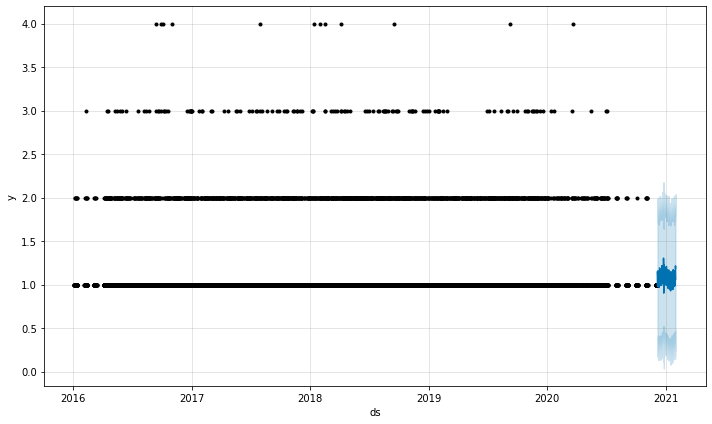

In [ ]:
stream_objects[2].prophet_model.plot(stream_objects[2].forecast_df);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4cc3d8f-976a-44f2-a841-ef4378fe07d2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>